In [51]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings

#### В данных отсутсвует наименование колонок, из открытых итсточников достанем структуру датасета и назначим имена колонок

In [52]:
columns = [
    "id", "diagnosis", "radius_mean", "texture_mean",
    "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave points_mean",
    "symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se",
    "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se",
    "concave points_se", "symmetry_se", "fractal_dimension_se", "radius_worst",
    "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave points_worst",
    "symmetry_worst", "fractal_dimension_worst"
]

In [53]:
# Качаем 
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  121k    0  121k    0     0  45390      0 --:--:--  0:00:02 --:--:-- 45375


In [54]:
df = pd.read_csv("wdbc.data", names=columns, header=0)

In [55]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [56]:
df["diagnosis"].value_counts(normalize=True).index

Index(['B', 'M'], dtype='object', name='diagnosis')

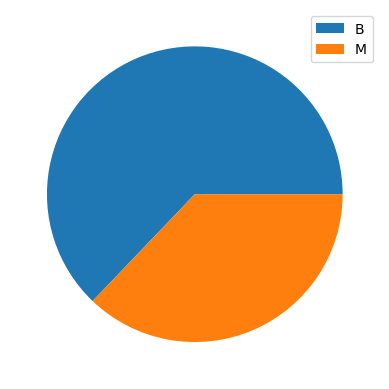

In [57]:
# Беглое отображение таргета
plt.pie(df["diagnosis"].value_counts(normalize=True))
plt.legend(df["diagnosis"].value_counts(normalize=True).index)
plt.show()

#### Таргет переменная именуется diagnosis, состоит из двух значений, следовательно можно заключить, что задача - бинарная классификация

---

#### Посмотри на данные, формат, наличие пропусков, дубликатов

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       568 non-null    int64  
 1   diagnosis                568 non-null    object 
 2   radius_mean              568 non-null    float64
 3   texture_mean             568 non-null    float64
 4   perimeter_mean           568 non-null    float64
 5   area_mean                568 non-null    float64
 6   smoothness_mean          568 non-null    float64
 7   compactness_mean         568 non-null    float64
 8   concavity_mean           568 non-null    float64
 9   concave points_mean      568 non-null    float64
 10  symmetry_mean            568 non-null    float64
 11  fractal_dimension_mean   568 non-null    float64
 12  radius_se                568 non-null    float64
 13  texture_se               568 non-null    float64
 14  perimeter_se             5

In [59]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.680000e+02,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,...,568.00000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000
mean,3.042382e+07,14.120491,19.305335,91.914754,654.279754,0.096321,0.104036,0.088427,0.048746,0.181055,...,16.25315,25.691919,107.125053,878.578873,0.132316,0.253541,0.271414,0.114341,0.289776,0.083884
std,1.251246e+08,3.523416,4.288506,24.285848,351.923751,0.014046,0.052355,0.079294,0.038617,0.027319,...,4.82232,6.141662,33.474687,567.846267,0.022818,0.156523,0.207989,0.065484,0.061508,0.018017
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.93000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692225e+05,11.697500,16.177500,75.135000,420.175000,0.086290,0.064815,0.029540,0.020310,0.161900,...,13.01000,21.095000,84.102500,514.975000,0.116600,0.146900,0.114475,0.064730,0.250350,0.071412
50%,9.061570e+05,13.355000,18.855000,86.210000,548.750000,0.095865,0.092525,0.061400,0.033455,0.179200,...,14.96500,25.425000,97.655000,685.550000,0.131300,0.211850,0.226550,0.099840,0.282050,0.080015
75%,8.825022e+06,15.780000,21.802500,103.875000,782.625000,0.105300,0.130400,0.129650,0.073730,0.195625,...,18.76750,29.757500,125.175000,1073.500000,0.146000,0.337600,0.381400,0.161325,0.317675,0.092065
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.04000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [60]:
# Посмотрим на наличие дубликатов
df.duplicated().sum()

0

> Дубликаты отсутсвуют

In [61]:
# Проверим пропуски
df.isna().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

> Пропусков нет

In [62]:
# Скинем индексы
df.drop(columns=["id"], inplace=True)

In [63]:
df_explore = df.copy()

In [64]:
df_explore["diagnosis"] = df_explore["diagnosis"].apply(
    lambda x: 1 if x == "M" else 0)

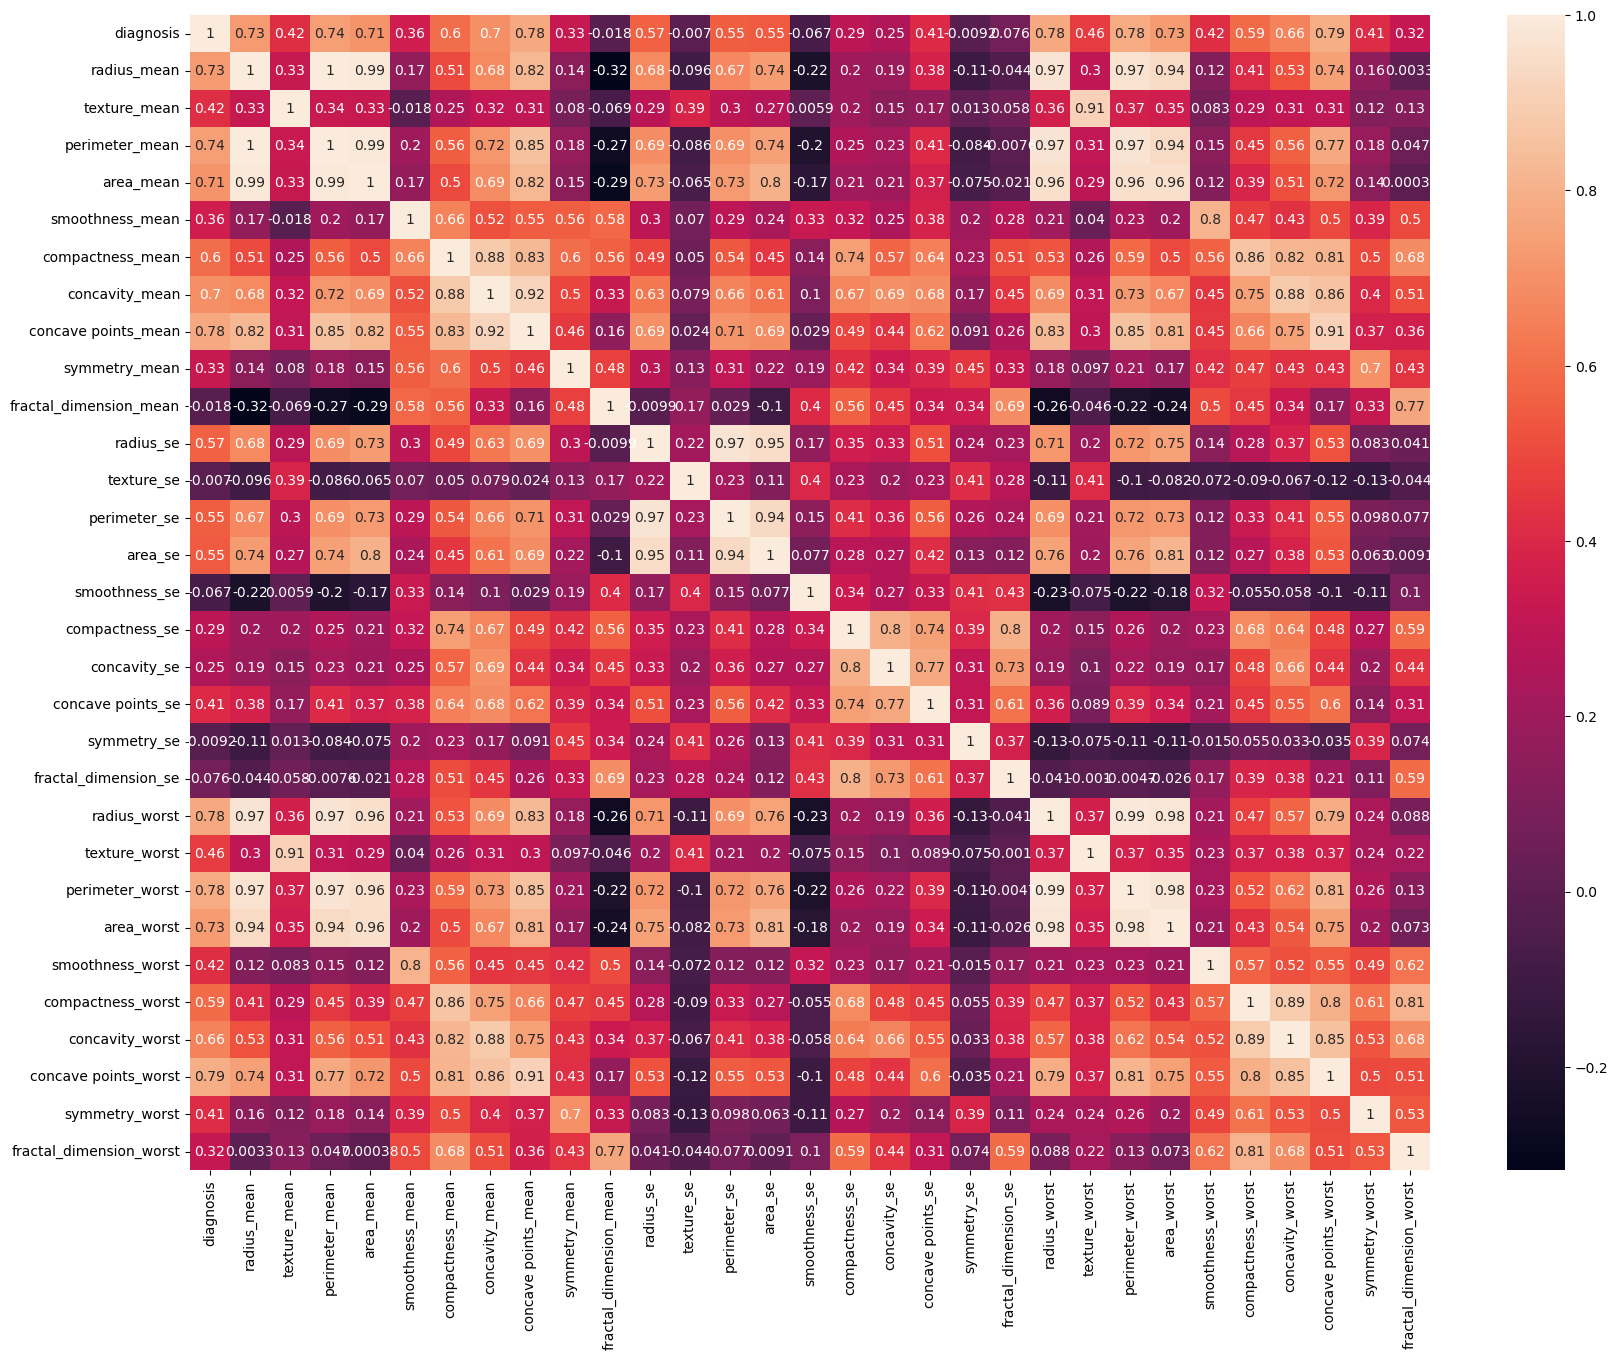

In [65]:
# Оценим мультиколлинераность
fig, axes = plt.subplots(figsize=(20,15))
sns.heatmap(df_explore.corr(), annot=True)
plt.savefig("heatmap.png")
plt.show()

> Видна отчетливая мультиколлинеарность данных, при этом высокое влияние скоррелированных признаков на таргет, для унификации будет использован, как шаг пайплайна - PCA

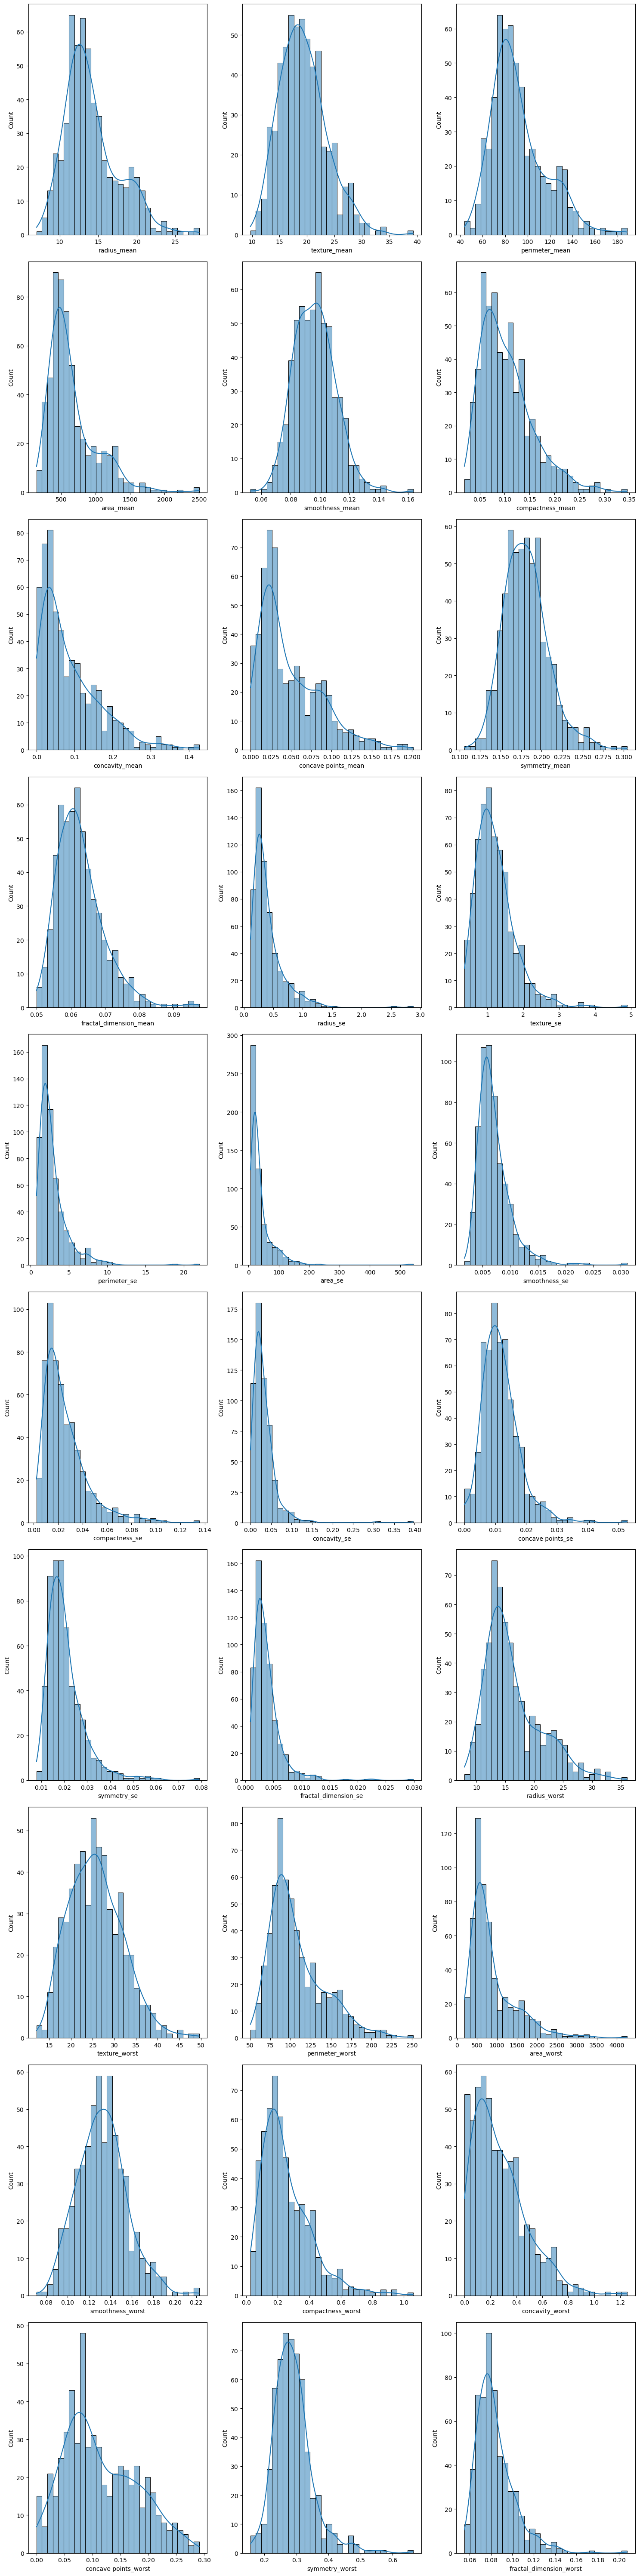

In [66]:
# Посмотрим на распределение предикторов
numeric_cols = df.select_dtypes(include=['number']).columns

fig, axes = plt.subplots(
    math.ceil(len(numeric_cols)/3),
    3, figsize=(15, len(numeric_cols)*2))

for i, (ax, col) in enumerate(zip(axes.flatten(), numeric_cols)):
    sns.histplot(df[col], ax=ax, kde=True, bins=30)
plt.tight_layout()
plt.savefig("distr.png")
plt.show()

#### Предикторы описываются числовыми значениями (кодирование не нужно) и находятся в разных масштабах, следовательно стандартизируем для лучшей сходимости алгоритма, таргет кодируем OneHot.

#### Так же нужно отметить, что часть предикторов имеет распределение ближе к логнормальному, или экспоненциальному, стоил провести логарифмирование признаков перед стандартизацией и проверить полученный результат.

In [73]:
X, y = df.drop(columns=["diagnosis"]), df["diagnosis"]

le = LabelEncoder()
y = le.fit_transform(df['diagnosis']) 

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.21)

In [112]:
pipeline = Pipeline([
    ('power_transform', PowerTransformer()), # преобразуем данные к более нормальному виду (использовал дефолт)
    ('scaler', StandardScaler()), # Центрируем
    ('pca', PCA()), # Метод главных компонент для очистки избыточности
    ('model', LogisticRegression(random_state=42)) # Собственно логистическая регрессия
])


In [113]:
with warnings.catch_warnings(): # перехватим предупреждения, а то некоторые комбинации параметров не сочетаются
    warnings.simplefilter("ignore")
    
    # Сетка параметров
    param_grid = {
        'power_transform__method': ['yeo-johnson'],
        'pca__n_components': [0.9, 0.95],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__fit_intercept': [True, False],
        'model__penalty': ['l1', 'l2', "elasticnet"]
    }

    # GridSearch
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5,
        scoring='accuracy', n_jobs=-1, verbose=1)
    
    grid_search.fit(X_train, y_train)

    # Результаты
    print("Лучшие параметры:", grid_search.best_params_)
    print("Точность на тесте:", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Лучшие параметры: {'model__C': 0.1, 'model__fit_intercept': True, 'model__penalty': 'l2', 'pca__n_components': 0.95, 'power_transform__method': 'yeo-johnson'}
Точность на тесте: 0.9833333333333333


In [114]:
# Посмотри на матрицу ошибок на предсказании моделью с лучшими параметрами
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      0.96      0.98        45

    accuracy                           0.98       120
   macro avg       0.99      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

[[75  0]
 [ 2 43]]
